# Country-level exposure

In this notebook, we will perform a **exposure analysis** for all available CI data within a country. The assessment is based on combining hazard data (e.g., flood depths) with OpenStreetMap feature data.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., roads) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the exposure assessment:**  
   We will overlay the hazard data with the feature information.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated exposure using graphs and maps.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b13
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Rwanda'
country_iso3 = 'RWA'

## 2. Loading the Data
In this step, we will prepare and load two key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

### Infrastructure Data

We will perform this example analysis for Jamaica. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

We will not load the data directly, we will let the code itself read the information. It is important, however, to specificy which infrastructure systems you want to include. We do so in the list below:

In [5]:
asset_types = [
        "roads",
        "main_roads",
        "rail",
        "air",
        "telecom",
        "water_supply",
        "waste_solid",
        "waste_water",
        "education",
        "healthcare",
        "power",
        "gas",
        "oil",
    ]

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [6]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

### Ancilliary data for processing

In [7]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [8]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [9]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

## 4. Performing the Exposure Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment.

In [10]:
save_asset_results = {}
for asset_type in asset_types:
    try:
        save_asset_results[asset_type] = DamageScanner(hazard_country, 
                                                       infrastructure_path, 
                                                       curves=pd.DataFrame(), 
                                                       maxdam=pd.DataFrame()).exposure(
            asset_type=asset_type
        )
    except:
        print(f"It seems that {asset_type} is most likely not mapped or has no exposure")

Overlay raster with vector: 100%|██████████████████████████████████████████████████████| 20/20 [00:00<00:00, 59.68it/s]
convert coverage to meters: 1it [00:00, 1501.72it/s]
Overlay raster with vector: 100%|█████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.21it/s]
convert coverage to meters: 1it [00:00, 973.38it/s]
convert coverage to meters: 100%|██████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1727.03it/s]


## 6. Visualizing the Results
The results of the exposure assessment can be visualized using charts and maps.

In [11]:
total_assets_per_type = {}
for asset_type in tqdm(asset_types,total=len(asset_types)):
    features = read_osm_data(infrastructure_path,asset_type=asset_type)
    total_assets_per_type[asset_type] = len(features)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [06:45<00:00, 31.21s/it]


In [12]:
number_of_assets_exposed = {}
for asset_type in asset_types:
    try:
        number_of_assets_exposed[asset_type] = len(save_asset_results[asset_type])
    except:
        None

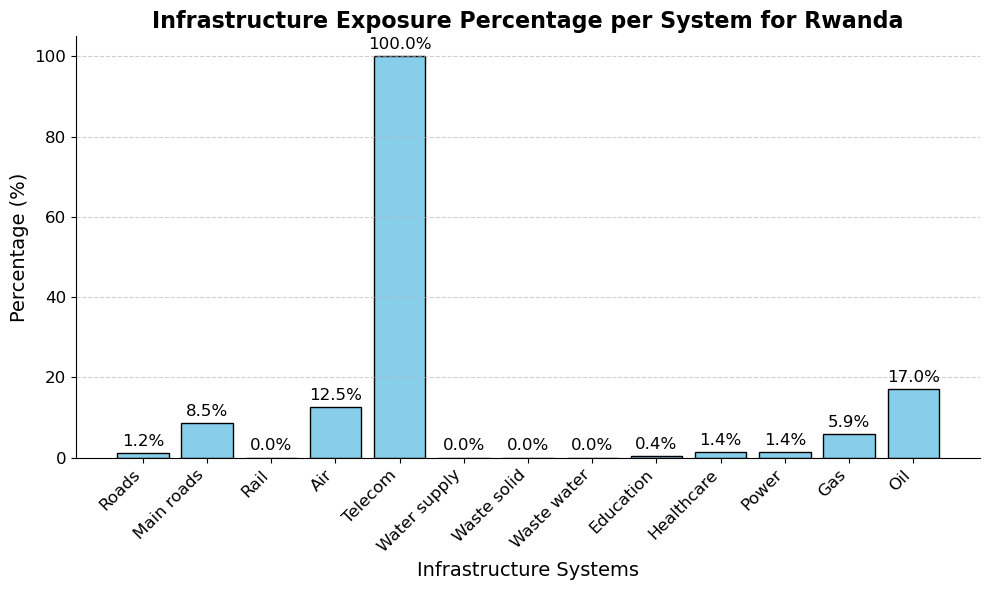

In [13]:
# Compute percentage of assets exposed per infrastructure system.
percentage_exposed = {}
for asset_type in total_assets_per_type:
    total = total_assets_per_type[asset_type]
    # Check if we have exposed count for the asset type; otherwise, assume 0
    exposed = number_of_assets_exposed.get(asset_type, 0)
    # Avoid division by zero by checking if total is zero.
    if total == 0:
        percentage_exposed[asset_type] = 0
    else:
        percentage_exposed[asset_type] = (exposed / total) * 100

# Update data keys for improved readability.
formatted_data = {key.replace('_', ' ').capitalize(): value for key, value in percentage_exposed.items()}

# Create figure with updated title and formatted categories.
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(formatted_data.keys(), formatted_data.values(), color='skyblue', edgecolor='black')

# Add labels and enhance aesthetics.
ax.set_title(f"Infrastructure Exposure Percentage per System for {country_full_name}", fontsize=16, weight='bold')
ax.set_ylabel("Percentage (%)", fontsize=14)
ax.set_xlabel("Infrastructure Systems", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with percentage values.
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()